In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as mlt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

In [4]:
df=pd.read_csv('/content/drive/MyDrive/star_classification.csv')
df.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237660e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543780e+18,GALAXY,0.634794,5812,56354,171
1,1.237660e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176010e+19,GALAXY,0.779136,10445,58158,427
2,1.237660e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237660e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030110e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891860e+18,GALAXY,0.116123,6121,56187,842


In [5]:
df.columns

Index(['obj_ID', 'alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'run_ID',
       'rerun_ID', 'cam_col', 'field_ID', 'spec_obj_ID', 'class', 'redshift',
       'plate', 'MJD', 'fiber_ID'],
      dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  object 
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
dtypes: float64(10), int64(7),

In [7]:
df.nunique()

,0
obj_ID,5
alpha,99997
delta,99999
u,93748
g,92651
r,91901
i,92019
z,92007
run_ID,430
rerun_ID,1


In [8]:
# Dropping unnecessary columns (e.g., 'obj_ID' and other identifiers which are not useful for prediction
df_cleaned = df.drop(columns=['obj_ID', 'spec_obj_ID', 'run_ID', 'rerun_ID', 'cam_col', 'field_ID', 'plate', 'MJD', 'fiber_ID'])

In [9]:
# Checking for missing values
print("Missing values in each column:")
print(df_cleaned.isnull().sum())

Missing values in each column:
alpha       0
delta       0
u           0
g           0
r           0
i           0
z           0
class       0
redshift    0
dtype: int64


In [10]:
# If there are any missing values, you can handle them (in this dataset, there are likely no missing values)
df_cleaned = df_cleaned.fillna(method='ffill')

<ipython-input-10-de88d392a1d1>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_cleaned = df_cleaned.fillna(method='ffill')


In [11]:
df_cleaned['class'].unique()

array(['GALAXY', 'QSO', 'STAR'], dtype=object)

In [12]:
# Mapping class labels ('Galaxy', 'Star', 'QSO') to integers for model training
df_cleaned['class']=df_cleaned['class'].map({'GALAXY': 0, 'STAR': 1, 'QSO': 2})

In [13]:
# Count the occurrences of each class (0, 1, and 2)
df_cleaned['class'].value_counts()

,count
class,
0,59445
1,21594
2,18961


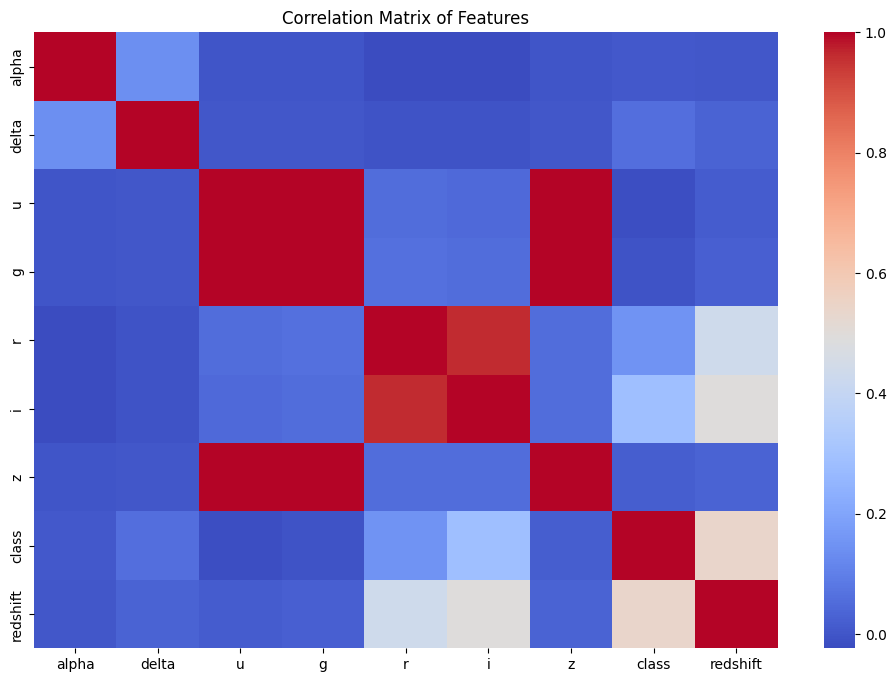

In [14]:
# Correlation Matrix
mlt.figure(figsize=(12, 8))
sns.heatmap(df_cleaned.corr(), cmap='coolwarm', annot=False)
mlt.title('Correlation Matrix of Features')
mlt.show()

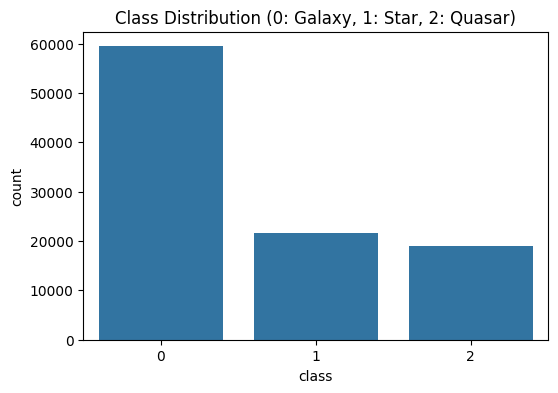

In [15]:
# Distribution of the target variable (Class)
mlt.figure(figsize=(6, 4))
sns.countplot(x='class', data=df_cleaned)
mlt.title('Class Distribution (0: Galaxy, 1: Star, 2: Quasar)')
mlt.show()

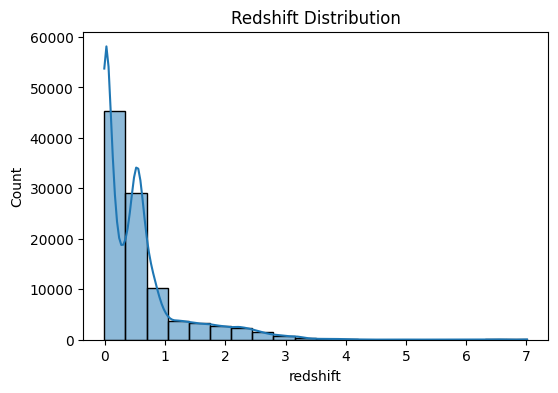

In [16]:
# Distribution of Redshift
mlt.figure(figsize=(6, 4))
sns.histplot(df_cleaned['redshift'], bins=20, kde=True)
mlt.title('Redshift Distribution')
mlt.show()

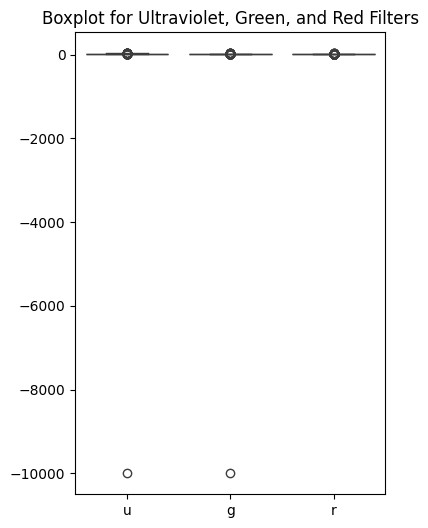

In [17]:
# Boxplot for u, g, r filters
mlt.figure(figsize=(4, 6))
sns.boxplot(data=df_cleaned[['u', 'g', 'r']])
mlt.title('Boxplot for Ultraviolet, Green, and Red Filters')
mlt.show()

In [18]:
# Defining features (X) and target (y)
X = df_cleaned.drop(columns=['class'])  # Features
y = df_cleaned['class']  # Target

# Splitting the data into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [19]:
# Applying Support Vector Machine (SVM) with RBF kernel
svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_train_scaled, y_train)

# Making predictions
y_pred = svm_model.predict(X_test_scaled)

# Evaluation metrics
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

In [20]:
# Displaying metrics
print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

Confusion Matrix:
[[17256   420   169]
 [   24  6431     0]
 [  527    14  5159]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     17845
           1       0.94      1.00      0.97      6455
           2       0.97      0.91      0.94      5700

    accuracy                           0.96     30000
   macro avg       0.96      0.96      0.96     30000
weighted avg       0.96      0.96      0.96     30000

Accuracy: 0.9615333333333334
Precision: 0.9619648168062476
Recall: 0.9615333333333334
F1-Score: 0.9613488762151103


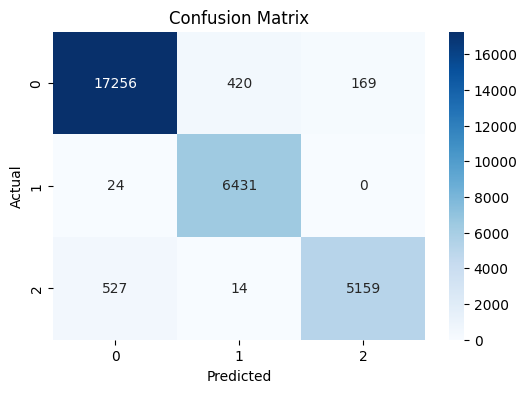

In [21]:
# Plot Confusion Matrix
mlt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
mlt.title('Confusion Matrix')
mlt.xlabel('Predicted')
mlt.ylabel('Actual')
mlt.show()